In [1]:
import os

actors = os.listdir('../../data/')
actors

['Aamir_Khan',
 'Abhay_Deol',
 'Abhishek_Bachchan',
 'Aftab_Shivdasani',
 'Aishwarya_Rai',
 'Ajay_Devgn',
 'Akshaye_Khanna',
 'Akshay_Kumar',
 'Alia_Bhatt',
 'Ameesha_Patel',
 'Amitabh_Bachchan',
 'Amrita_Rao',
 'Amy_Jackson',
 'Anil_Kapoor',
 'Anushka_Sharma',
 'Anushka_Shetty',
 'Arjun_Kapoor',
 'Arjun_Rampal',
 'Arshad_Warsi',
 'Asin',
 'Ayushmann_Khurrana',
 'Bhumi_Pednekar',
 'Bipasha_Basu',
 'Bobby_Deol',
 'Deepika_Padukone',
 'Disha_Patani',
 'Emraan_Hashmi',
 'Esha_Gupta',
 'Farhan_Akhtar',
 'Govinda',
 'Hrithik_Roshan',
 'Huma_Qureshi',
 'Ileana_DCruz',
 'Irrfan_Khan',
 'Jacqueline_Fernandez',
 'John_Abraham',
 'Juhi_Chawla',
 'Kajal_Aggarwal',
 'Kajol',
 'Kangana_Ranaut',
 'Kareena_Kapoor',
 'Karisma_Kapoor',
 'Kartik_Aaryan',
 'Katrina_Kaif',
 'Kiara_Advani',
 'Kriti_Kharbanda',
 'Kriti_Sanon',
 'Kunal_Khemu',
 'Lara_Dutta',
 'Madhuri_Dixit',
 'Manoj_Bajpayee',
 'Mrunal_Thakur',
 'Nana_Patekar',
 'Nargis_Fakhri',
 'Naseeruddin_Shah',
 'Nushrat_Bharucha',
 'Paresh_Rawal',
 'P

In [2]:
filenames = []

for actor in actors:
    for file in os.listdir(os.path.join('../../data', actor)):
        filenames.append(os.path.join('../../data', actor, file))

filenames

['../../data\\Aamir_Khan\\Aamir.100.jpg',
 '../../data\\Aamir_Khan\\Aamir.101.jpg',
 '../../data\\Aamir_Khan\\Aamir.103.jpg',
 '../../data\\Aamir_Khan\\Aamir.105.jpg',
 '../../data\\Aamir_Khan\\Aamir.106.jpg',
 '../../data\\Aamir_Khan\\Aamir.111.jpg',
 '../../data\\Aamir_Khan\\Aamir.112.jpg',
 '../../data\\Aamir_Khan\\Aamir.113.jpg',
 '../../data\\Aamir_Khan\\Aamir.115.jpg',
 '../../data\\Aamir_Khan\\Aamir.116.jpg',
 '../../data\\Aamir_Khan\\Aamir.118.jpg',
 '../../data\\Aamir_Khan\\Aamir.120.jpg',
 '../../data\\Aamir_Khan\\Aamir.121.jpg',
 '../../data\\Aamir_Khan\\Aamir.123.jpg',
 '../../data\\Aamir_Khan\\Aamir.125.jpg',
 '../../data\\Aamir_Khan\\Aamir.128.jpg',
 '../../data\\Aamir_Khan\\Aamir.129.jpg',
 '../../data\\Aamir_Khan\\Aamir.130.jpg',
 '../../data\\Aamir_Khan\\Aamir.132.jpg',
 '../../data\\Aamir_Khan\\Aamir.134.jpg',
 '../../data\\Aamir_Khan\\Aamir.142.jpg',
 '../../data\\Aamir_Khan\\Aamir.144.jpg',
 '../../data\\Aamir_Khan\\Aamir.151.jpg',
 '../../data\\Aamir_Khan\\Aamir.15

In [3]:
from tensorflow.keras.preprocessing import image
from keras_vggface.utils import preprocess_input
from keras_vggface.vggface import VGGFace
import numpy as np


def get_features(img_path, model):
    img = image.load_img(img_path, target_size=(224, 224))
    img = image.img_to_array(img)
    expanded_array = np.expand_dims(img, axis=0)
    preprocessed = preprocess_input(expanded_array)

    return model.predict(preprocessed).flatten()

In [9]:
from tqdm import tqdm
features = []

model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3))

for file in tqdm(filenames):
    features.append(get_features(file, model))


100%|██████████| 8466/8466 [27:50<00:00,  5.07it/s]  


In [ ]:
from dotenv import load_dotenv
load_dotenv()
api_key = os.getenv("PINECONE_API_KEY")
print(api_key)

In [ ]:
from pinecone import Pinecone, ServerlessSpec

api_key = os.getenv("PINECONE_API_KEY")

pc = Pinecone(api_key=api_key)

index_name = "face-features"

index = pc.create_index(name=index_name, metric="cosine", dimension=features[0].shape[0], spec=ServerlessSpec(
    cloud="aws",
    region="us-east-1",
))


In [ ]:
index = pc.Index(index_name)

records= []

for file, feature in tqdm(zip(filenames, features)):
    records.append(
        {
            "id": file,
            "values": feature, "metadata": {"actor": " ".join(file.split('/')[-1].split('\\')[1].split('_'))}}
        )

8466it [00:00, 189186.48it/s]


In [ ]:
# split records into batches of 10
from tqdm import tqdm

batch_size = 10
batches = [records[i:i + batch_size] for i in range(0, len(records), batch_size)]

for batch in tqdm(batches):
    index.upsert(vectors=batch, namespace="first")


100%|██████████| 847/847 [22:38<00:00,  1.60s/it]


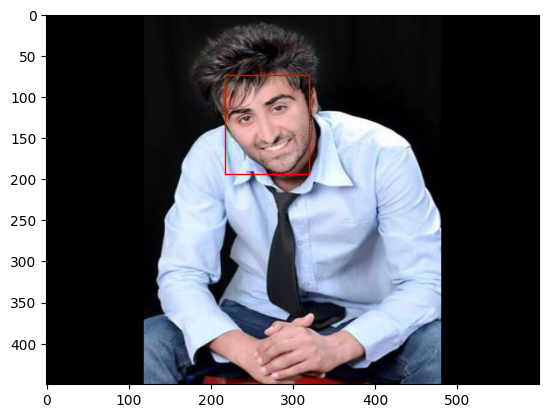

In [66]:
from mtcnn import MTCNN
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

detector = MTCNN()

img = Image.open(r'..\test\ranbir_duplicate.png')
result = detector.detect_faces(np.array(img))


bounding_box = result[0]['box']
# draw the bounding box in matplotlib
plt.imshow(img)
plt.gca().add_patch(plt.Rectangle((bounding_box[0], bounding_box[1]), bounding_box[2], bounding_box[3], fill=False, color='red'))

In [73]:
x, y, width, height = bounding_box
face = img.crop((x, y, x + width, y + height))
face = face.resize((224, 224))
face_array = np.asarray(face)
face_array = face_array.astype('float32')

expanded_array = np.expand_dims(face_array, axis=0)
preprocessed_img = preprocess_input(expanded_array)

result = model.predict(preprocessed_img).flatten()
# # print(result.shape)
print(result)


[0.04795027 4.1412196  0.13452977 ... 8.087401   3.3196177  1.9144909 ]


In [77]:
ans = index.query(vector=result.tolist(), top_k=5, namespace="first", include_values=False, include_metadata=True)
ans

{'matches': [{'id': '../../data\\Ranbir_Kapoor\\Ranbir_Kapoor.53.jpg',
              'metadata': {'actor': 'Ranbir Kapoor'},
              'score': 0.635561824,
              'values': []},
             {'id': '../../data\\Ayushmann_Khurrana\\Ayushmann_Khurrana.346.jpg',
              'metadata': {'actor': 'Ayushmann Khurrana'},
              'score': 0.6246292,
              'values': []},
             {'id': '../../data\\Ayushmann_Khurrana\\Ayushmann_Khurrana.132.jpg',
              'metadata': {'actor': 'Ayushmann Khurrana'},
              'score': 0.620960236,
              'values': []},
             {'id': '../../data\\Ranbir_Kapoor\\Ranbir_Kapoor.108.jpg',
              'metadata': {'actor': 'Ranbir Kapoor'},
              'score': 0.602231562,
              'values': []},
             {'id': '../../data\\Ranbir_Kapoor\\Ranbir_Kapoor.311.jpg',
              'metadata': {'actor': 'Ranbir Kapoor'},
              'score': 0.595867932,
              'values': []}],
 'namespace': 'fi

Ranbir Kapoor
..\..\data\Ranbir_Kapoor\Ranbir_Kapoor.53.jpg


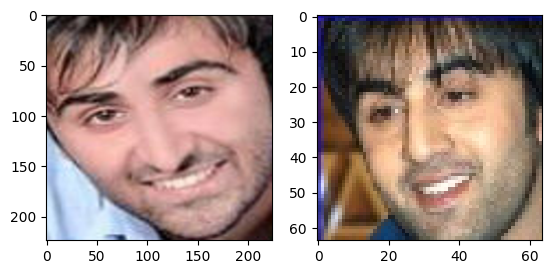

In [92]:
print(ans['matches'][0]['metadata']['actor'])
img_path = ans['matches'][0]['id']
img_path = img_path.replace('/', '\\')
print(img_path)
ans_img = Image.open(img_path)

# compare the original and the given image side by side
fig, ax = plt.subplots(1, 2)
ax[0].imshow(face)
ax[1].imshow(ans_img)
plt.show()